In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from khayyam import JalaliDate
import jdatetime
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objs as go
import plotly.subplots as sp
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings("ignore")

 ## Check for Stationarity 

In [93]:

df = pd.read_csv("/home/ccp/Desktop/task1/Stores_Transactions .csv")
# Convert the 'transaction_date' from Shamsi to Gregorian
def convert_shamsi_to_gregorian(shamsi_date):
    year, month, day = map(int, shamsi_date.split('-'))
    g_date = jdatetime.date(year, month, day).togregorian()
    return g_date

# Apply the conversion function to the 'transaction_date' column
df['transaction_date'] = df['transaction_date'].apply(convert_shamsi_to_gregorian)
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df = df.sort_values("transaction_date")
df['month'] = df['transaction_date'].dt.to_period('M') 

# Sum the quantity for each month
monthly_demand = df.groupby('month')['quantity'].sum()




In [94]:


# Convert the index to a DateTimeIndex with monthly frequency
monthly_demand.index = monthly_demand.index.to_timestamp()

# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(monthly_demand, model='additive', period=3)  # Adjust period as needed

# Trend Component Insights
trend_start = decomposition.trend.iloc[0]
trend_end = decomposition.trend.iloc[-1]
trend_change = trend_end - trend_start
print(f"Trend Component: \nStart Value: {trend_start:.2f}, End Value: {trend_end:.2f}, Change: {trend_change:.2f}")
if trend_change > 0:
    print("The trend shows an overall increase in demand over time.")
else:
    print("The trend shows a decrease in demand over time.")

# Seasonal Component Insights
seasonal_max = decomposition.seasonal.max()
seasonal_min = decomposition.seasonal.min()
seasonal_mean = decomposition.seasonal.mean()
print(f"\nSeasonal Component: \nMaximum Seasonal Value: {seasonal_max:.2f}, Minimum Seasonal Value: {seasonal_min:.2f}, Mean Seasonal Value: {seasonal_mean:.2f}")
print("The seasonal component indicates periodic fluctuations in demand. The maximum and minimum points highlight peak and off-peak seasons.")

# Residual Component Insights
residual_max = decomposition.resid.max()
residual_min = decomposition.resid.min()
residual_mean = decomposition.resid.mean()
residual_std = decomposition.resid.std()
print(f"\nResidual Component: \nMaximum Residual Value: {residual_max:.2f}, Minimum Residual Value: {residual_min:.2f}, Mean Residual Value: {residual_mean:.2f}, Standard Deviation: {residual_std:.2f}")
if abs(residual_max) > 2 * residual_std:
    print("There are some significant residuals indicating large deviations from the expected behavior.")

# Original Data Insights
original_max = monthly_demand.max()
original_min = monthly_demand.min()
original_mean = monthly_demand.mean()
print(f"\nOriginal Data: \nMaximum Value: {original_max:.2f}, Minimum Value: {original_min:.2f}, Mean Value: {original_mean:.2f}")
print("The original data shows the raw demand values over time, combining both seasonal effects and trends.")

# Create subplots for decomposition components
fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                       subplot_titles=('Trend Component', 'Seasonal Component', 'Residual Component', 'Original Data'))


fig.add_trace(go.Scatter(x=decomposition.trend.index, y=decomposition.trend, mode='lines', name='Trend', line=dict(color='blue')),
              row=1, col=1)


fig.add_trace(go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal, mode='lines', name='Seasonality', line=dict(color='orange')),
              row=2, col=1)


fig.add_trace(go.Scatter(x=decomposition.resid.index, y=decomposition.resid, mode='lines', name='Residuals', line=dict(color='green')),
              row=3, col=1)


fig.add_trace(go.Scatter(x=monthly_demand.index, y=monthly_demand, mode='lines', name='Original Data', line=dict(color='black')),
              row=4, col=1)


fig.update_layout(
    title='Decomposition of Time Series: Insights into Demand Behavior',
    title_x=0.5,
    height=800,
    showlegend=True,
    xaxis_title='Date',
    yaxis_title='Value',
    plot_bgcolor='white',
    template='plotly_dark'
)


fig.update_xaxes(tickangle=45, showgrid=True)
fig.update_yaxes(showgrid=True)


fig.show()


Trend Component: 
Start Value: nan, End Value: nan, Change: nan
The trend shows a decrease in demand over time.

Seasonal Component: 
Maximum Seasonal Value: 236.28, Minimum Seasonal Value: -156.06, Mean Seasonal Value: 10.03
The seasonal component indicates periodic fluctuations in demand. The maximum and minimum points highlight peak and off-peak seasons.

Residual Component: 
Maximum Residual Value: 533.72, Minimum Residual Value: -194.61, Mean Residual Value: 169.56, Standard Deviation: 246.63
There are some significant residuals indicating large deviations from the expected behavior.

Original Data: 
Maximum Value: 3672.00, Minimum Value: 1038.00, Mean Value: 3036.75
The original data shows the raw demand values over time, combining both seasonal effects and trends.


In [95]:

# Perform ADF Test on the monthly demand series
result = adfuller(monthly_demand)

print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpret the p-value
if result[1] < 0.05:
    print("The series is stationary")
else:
    print("The series is non-stationary, apply differencing")


ADF Statistic: 8.717089942655047
p-value: 1.0
The series is non-stationary, apply differencing


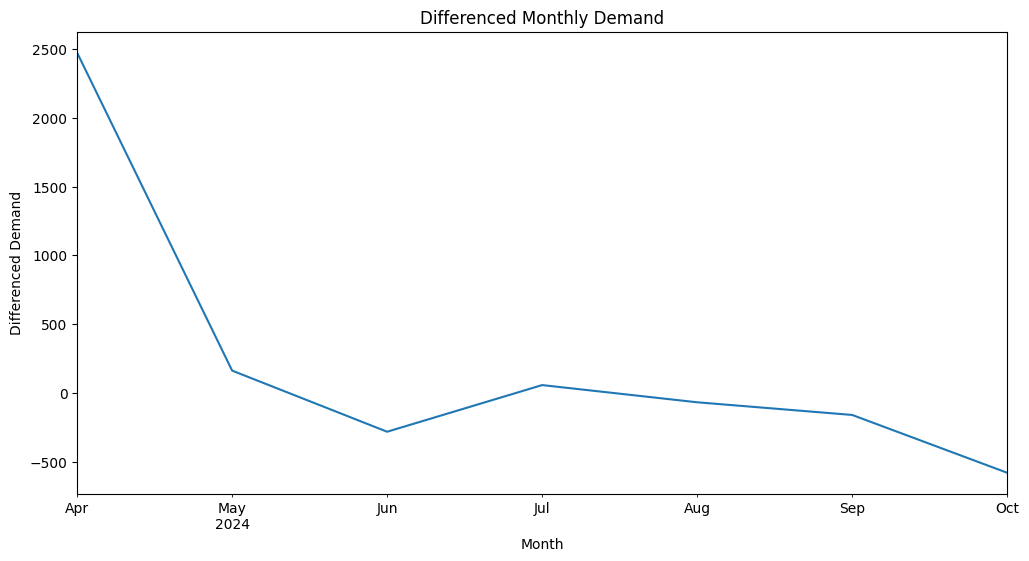

ADF Statistic: -8.137793511558504
p-value: 1.047770598352632e-12
The series is stationary


In [96]:
# Apply first differencing to remove trend
monthly_demand_diff = monthly_demand.diff().dropna()

# Plot the differenced series
monthly_demand_diff.plot(figsize=(12, 6))
plt.title("Differenced Monthly Demand")
plt.xlabel("Month")
plt.ylabel("Differenced Demand")
plt.show()

# Recheck stationarity after differencing
result = adfuller(monthly_demand_diff)

print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpret the p-value
if result[1] < 0.05:
    print("The series is stationary")
else:
    print("The series is non-stationary, apply differencing")



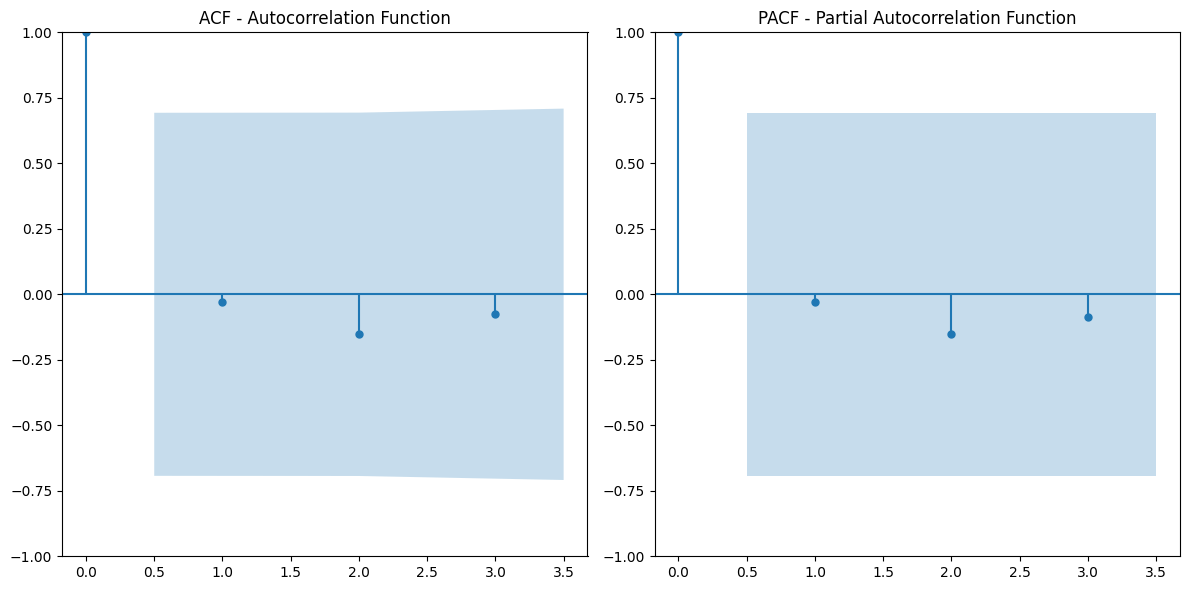

In [97]:
# Plot ACF and PACF with fewer lags
plt.figure(figsize=(12, 6))

# ACF Plot (for q)
plt.subplot(121)
plot_acf(monthly_demand, lags=3, ax=plt.gca())  # Limit lags to 3
plt.title('ACF - Autocorrelation Function')

# PACF Plot (for p)
plt.subplot(122)
plot_pacf(monthly_demand, lags=3, ax=plt.gca())  # Limit lags to 3
plt.title('PACF - Partial Autocorrelation Function')

plt.tight_layout()
plt.show()



                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                    8
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -57.142
Date:                Tue, 25 Feb 2025   AIC                            124.283
Time:                        13:09:08   BIC                            124.013
Sample:                    03-01-2024   HQIC                           120.940
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7056      1.018      0.693      0.488      -1.290       2.701
ar.L2         -0.1157      1.207     -0.096      0.924      -2.481       2.250
ma.L1         -0.0034    283.912   -1.2e-05      1.0

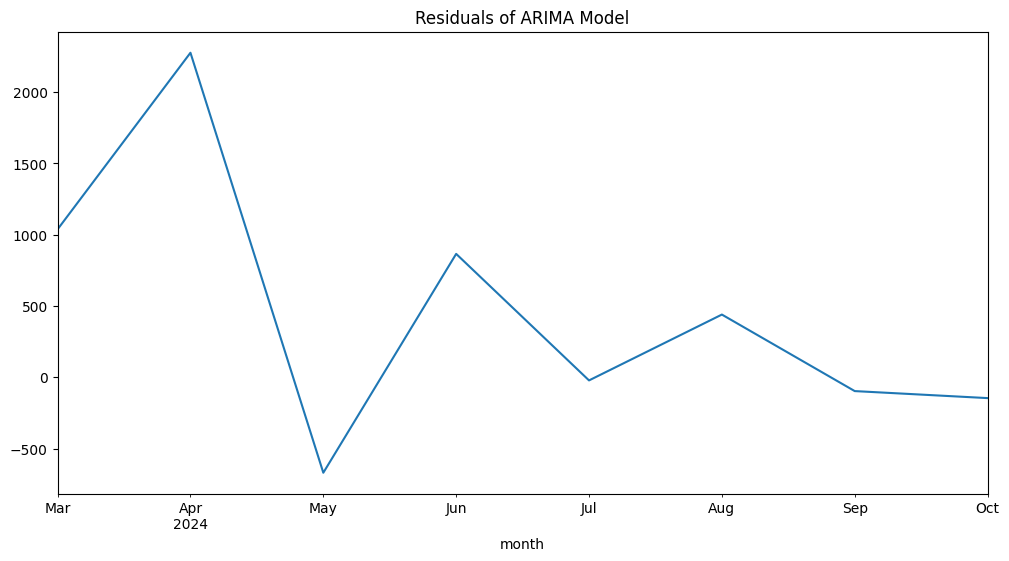

Forecasted values for next 12 months: 2024-11-01    2328.213787
2024-12-01    2293.394074
2025-01-01    2304.795390
2025-02-01    2316.869438
2025-03-01    2324.068800
2025-04-01    2327.750954
2025-05-01    2329.515700
2025-06-01    2330.334671
2025-07-01    2330.708258
2025-08-01    2330.877061
2025-09-01    2330.952923
2025-10-01    2330.986912
Freq: MS, Name: predicted_mean, dtype: float64


In [98]:
# Fit ARIMA model 
model = ARIMA(monthly_demand, order=(2, 1, 2))  # Here we assume d=1 as we differenced once
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Plot the model's residuals to check for randomness (this ensures the model has fitted well)
model_fit.resid.plot(figsize=(12, 6))
plt.title('Residuals of ARIMA Model')
plt.show()

# Forecast the future values (e.g., next 12 months)
forecast = model_fit.forecast(steps=12)
print("Forecasted values for next 12 months:", forecast)



                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                    8
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -57.142
Date:                Tue, 25 Feb 2025   AIC                            124.283
Time:                        12:57:07   BIC                            124.013
Sample:                    03-01-2024   HQIC                           120.940
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7056      1.018      0.693      0.488      -1.290       2.701
ar.L2         -0.1157      1.207     -0.096      0.924      -2.481       2.250
ma.L1         -0.0034    283.912   -1.2e-05      1.0

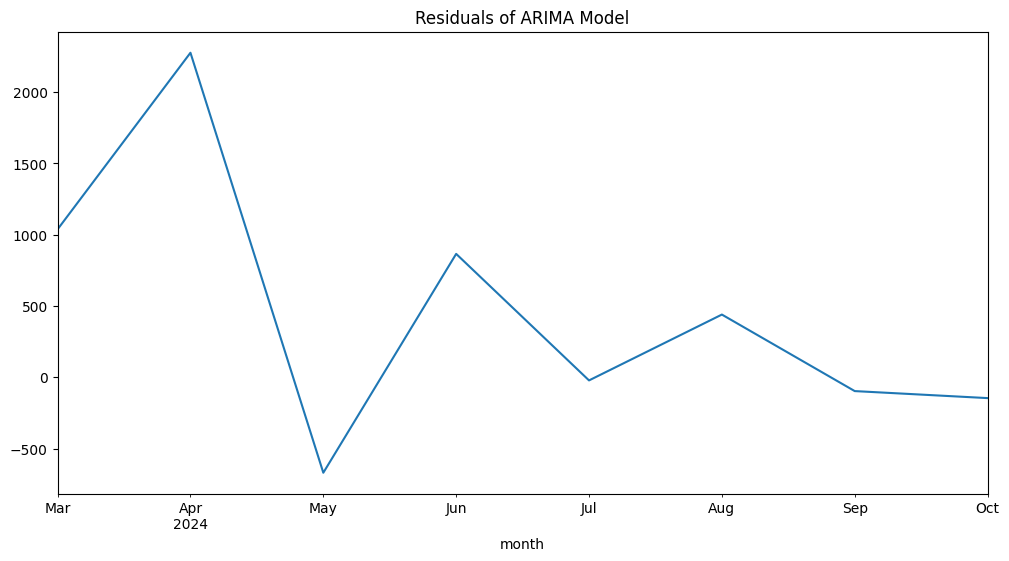

Forecasted values for next 12 months: 2024-11-01    2328.213787
2024-12-01    2293.394074
2025-01-01    2304.795390
2025-02-01    2316.869438
2025-03-01    2324.068800
2025-04-01    2327.750954
2025-05-01    2329.515700
2025-06-01    2330.334671
2025-07-01    2330.708258
2025-08-01    2330.877061
2025-09-01    2330.952923
2025-10-01    2330.986912
Freq: MS, Name: predicted_mean, dtype: float64


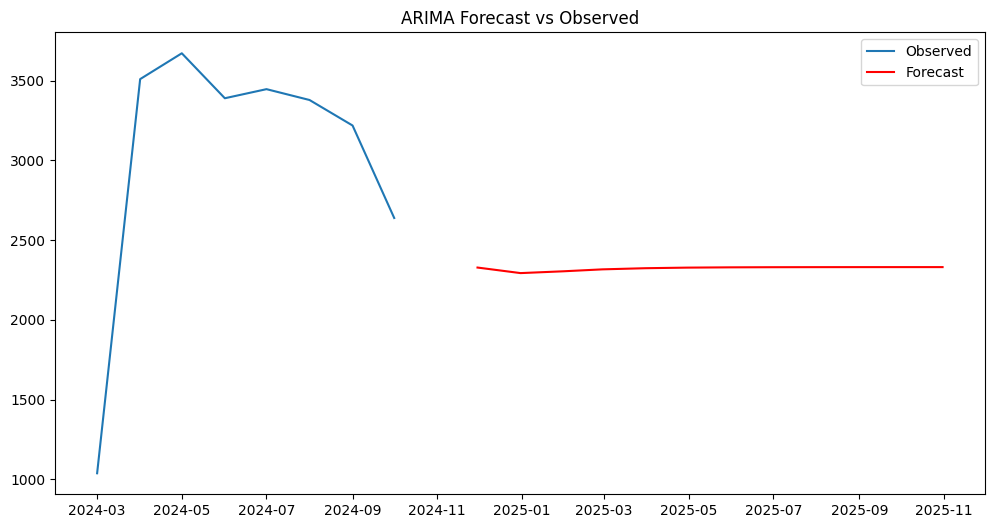

In [ ]:
# Fit ARIMA model 
model = ARIMA(monthly_demand, order=(2, 1, 2)) 
model_fit = model.fit()

print(model_fit.summary())

# Plot the model's residuals to check for randomness (this ensures the model has fitted well)
model_fit.resid.plot(figsize=(12, 6))
plt.title('Residuals of ARIMA Model')
plt.show()

# Forecast the future values 
forecast = model_fit.forecast(steps=12)

# Print forecasted values
print("Forecasted values for next 12 months:", forecast)

#Plot the forecasted values along with the original data
plt.figure(figsize=(12, 6))
plt.plot(monthly_demand, label='Observed')
plt.plot(pd.date_range(monthly_demand.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Observed')
plt.legend()
plt.show()


                                      SARIMAX Results                                       
Dep. Variable:                             quantity   No. Observations:                    8
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                   0.000
Date:                              Tue, 25 Feb 2025   AIC                             14.000
Time:                                      12:58:03   BIC                                nan
Sample:                                  03-01-2024   HQIC                               nan
                                       - 10-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ar.L2              

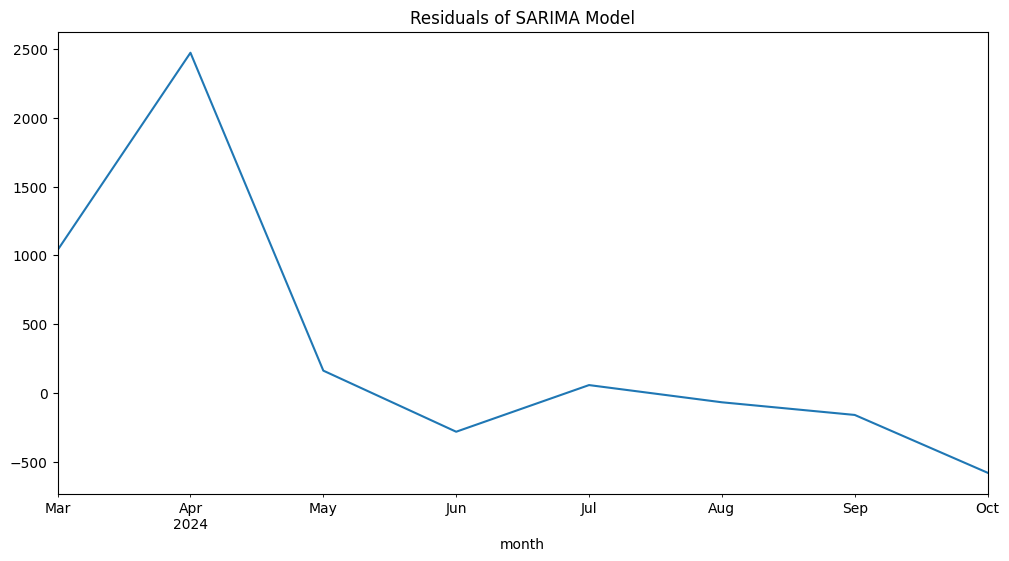

Forecasted values for next 12 months: 2024-11-01    2639.0
2024-12-01    2639.0
2025-01-01    2639.0
2025-02-01    2639.0
2025-03-01    3331.0
2025-04-01    5803.0
2025-05-01    5965.0
2025-06-01    5683.0
2025-07-01    5740.0
2025-08-01    5672.0
2025-09-01    5512.0
2025-10-01    4932.0
Freq: MS, Name: predicted_mean, dtype: float64


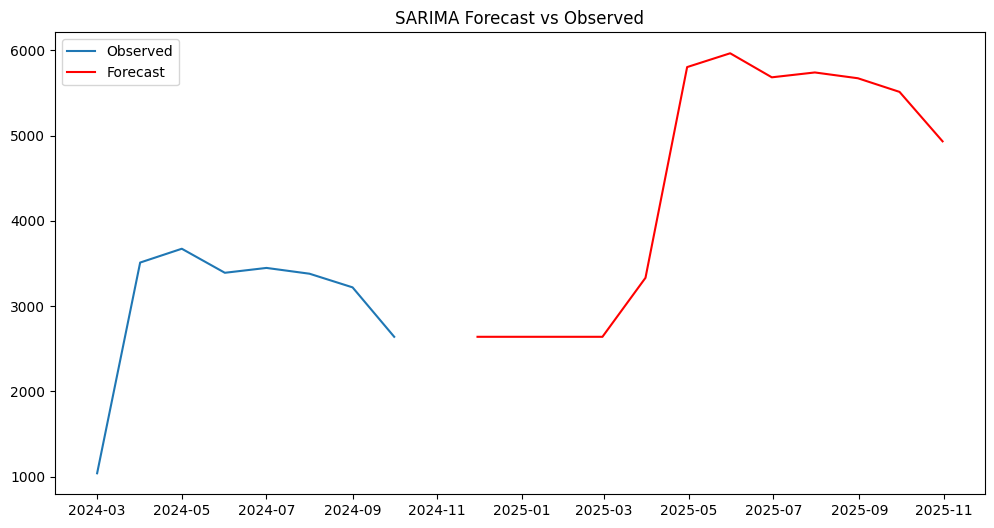

In [87]:

model = SARIMAX(monthly_demand, 
                order=(2, 1, 2),        # Non-seasonal ARIMA order (p, d, q)
                seasonal_order=(1, 1, 1, 12),  # Seasonal ARIMA order (P, D, Q, S)
                enforce_stationarity=False,   # Optional: can be True if you want to enforce stationarity
                enforce_invertibility=False)  # Optional: can be True if you want to enforce invertibility

# Fit the model
model_fit = model.fit()

print(model_fit.summary())

# Plot the model's residuals to check for randomness (this ensures the model has fitted well)
model_fit.resid.plot(figsize=(12, 6))
plt.title('Residuals of SARIMA Model')
plt.show()

# Forecast the future values (e.g., next 12 months)
forecast = model_fit.forecast(steps=12)

# Print forecasted values
print("Forecasted values for next 12 months:", forecast)

plt.figure(figsize=(12, 6))
plt.plot(monthly_demand, label='Observed')
plt.plot(pd.date_range(monthly_demand.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='red')
plt.title('SARIMA Forecast vs Observed')
plt.legend()
plt.show()
